In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
t = np.linspace(0, 2*np.pi, 1000)

In [3]:
E = np.cos(4*t)[:, None]

mat = (1-(E @ E.T))
mat = mat - np.min(mat) + 0.1

In [4]:
distance = np.linspace(0, 5, 1000)

distance_r2 = np.abs(distance[:, None] - distance[None, :])**1.2 + 1e-1

In [5]:
fake_mat = mat/distance_r2

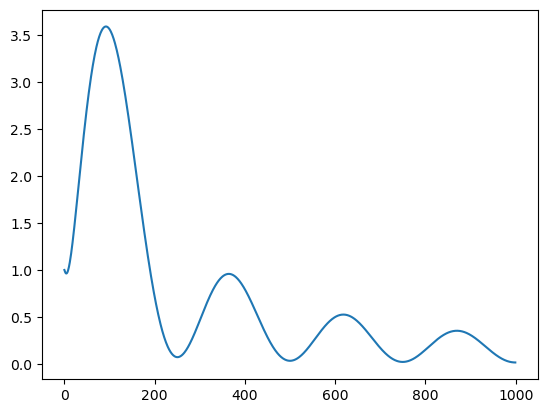

In [6]:
plt.plot(fake_mat[0])

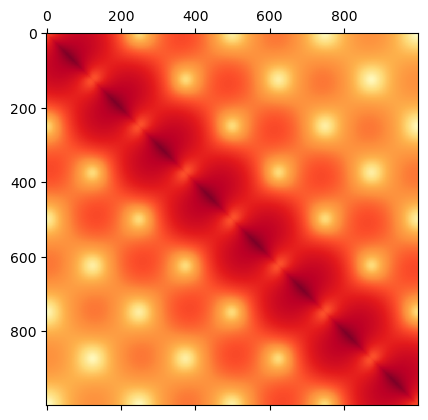

In [7]:
plt.matshow(np.log(fake_mat), cmap='YlOrRd')

In [8]:
X = torch.tensor(t).type(torch.float)[:, None]
Y = torch.tensor(np.log(fake_mat)).type(torch.float)

In [9]:
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from torch import nn
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [10]:
class CustomLikelihood(nn.Module):
    def __init__(self, gp1, gp2, noise=0.1):
        super().__init__()
        self.gp1 = gp1
        self.gp2 = gp2

        self.noise = nn.Parameter(torch.tensor(noise))

    def forward(self, X, E=1, verbose=False, **kwargs):
        qF1, qU1, pU1 = self.gp1(X, verbose=verbose, **kwargs)
        
        X2 = qF1.rsample().T    
        
        qF2, qU2, pU2 = self.gp2(X2, verbose=verbose, **kwargs)
        
        
        
        F2 = qF2.rsample((E, )) #E x L x N
        F2_T = torch.transpose(F2, -1, -2)
        mean = F2_T @ F2
        
        noise = torch.nn.functional.softplus(self.noise) #ensure positive
        pY = distributions.Normal(mean, noise)

        return pY, qF1, qU1, pU1, qF2, qU2, pU2
    
    def predict(self, X, verbose=False, **kwargs):
        qF1, qU1, pU1 = self.gp1(X, verbose=verbose, **kwargs)
        
        X2 = qF1.mean.T    
        
        qF2, qU2, pU2 = self.gp2(X2, verbose=verbose, **kwargs)
        

        return qF1, qU1, pU1, qF2, qU2, pU2

In [11]:
L = 3
M = 300
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=0.5, lengthscale=1.2)
gp = SVGP(kernel, M=M, jitter=1e-1)
gp.Lu = nn.Parameter(1e-2*torch.eye(M).expand(L, M, M).clone())
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)
mu =  torch.squeeze(torch.stack((torch.torch.sin(gp.Z), torch.cos(gp.Z), torch.sin(gp.Z))))
gp.mu = nn.Parameter(mu)


gp2_L = 10
kernel2 = NSF_RBF(L=gp2_L, sigma=0.5, lengthscale=1.2)
gp2 = SVGP(kernel2, M=M, jitter=1e-1)
gp2.Lu = nn.Parameter(1e-2*torch.eye(M).expand(gp2_L, M, M).clone())
gp2.Z = nn.Parameter(mu.T, requires_grad=True)
gp2.mu = nn.Parameter(torch.zeros(gp2_L, M))



/tmp/ipykernel_1396554/3401375193.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


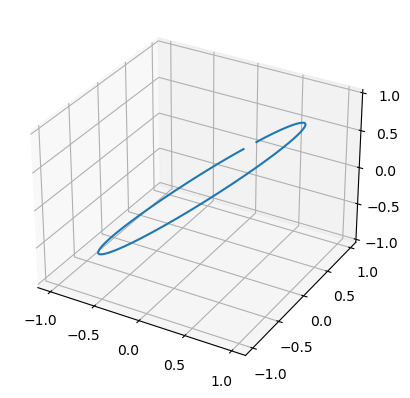

In [12]:
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection='3d')

qF, _, _ = gp(X)
some_mean = qF.mean.detach().numpy()

ax.plot(some_mean[0], some_mean[1], some_mean[2])

In [13]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [14]:
model = CustomLikelihood(gp1=gp, gp2=gp2, noise=0.1)
model.to(device)

CustomLikelihood(
  (gp1): SVGP(
    (kernel): NSF_RBF()
  )
  (gp2): SVGP(
    (kernel): NSF_RBF()
  )
)

In [15]:
X_train = X.to(device)
Y_train = Y.to(device)

In [16]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF1, qU1, pU1, qF2, qU2, pU2 = model.forward(X=X, E=E, **kwargs)
        if (it%10)==0:
            means.append(qF1.mean.detach().cpu().numpy())
            scales.append(qF1.scale.detach().cpu().numpy())

        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU1, pU1))
        ELBO -= torch.sum(distributions.kl_divergence(qU2, pU2))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [17]:
kernel.lengthscale.requires_grad = False
kernel.sigma.requires_grad = False
model.noise.requires_grad=False
gp.Lu.requires_grad=False

kernel2.lengthscale.requires_grad = False
kernel2.sigma.requires_grad = False
gp2.Lu.requires_grad=False

In [18]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [19]:
model.to(device)
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=1000, E=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

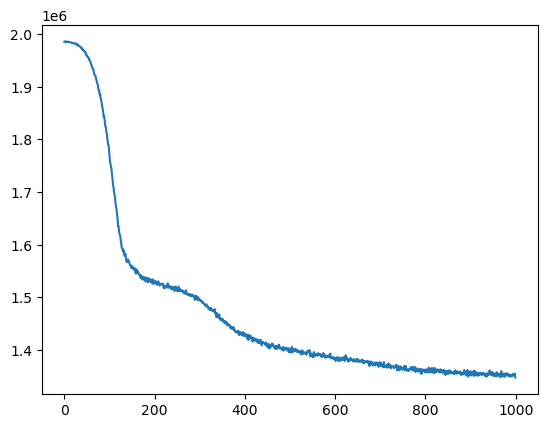

In [20]:
plt.plot(losses)

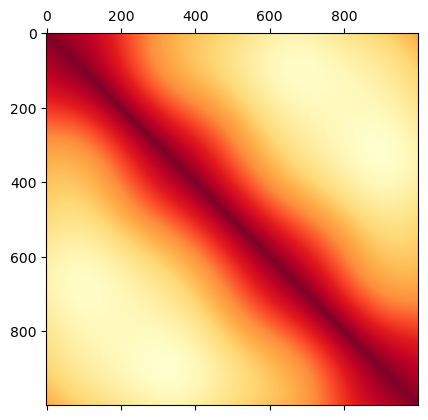

In [21]:
curr_mean = torch.tensor(means[-1].T)
mat = torch.cdist(curr_mean, curr_mean)
plt.matshow(mat, cmap='YlOrRd_r')

In [22]:
def plot_mean(ax, curr_mean):
    ax.plot(curr_mean[0], curr_mean[1], curr_mean[2], label='parametric curve')
    ax.legend()

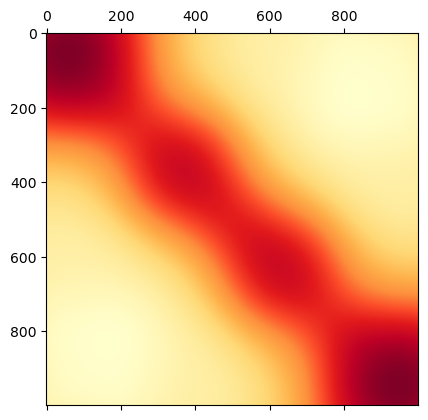

In [23]:
model.cpu()
X_test = torch.tensor(np.linspace(0, 2*np.pi, 1000)[:, None], dtype=torch.float)
qF1, qU1, pU1, qF2, qU2, pU2 = model.predict(X=X_test)

plt.matshow((qF2.mean.T @ qF2.mean).detach().numpy(), cmap='YlOrRd')

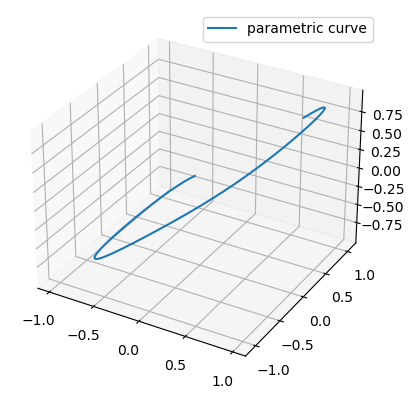

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(projection='3d')



plot_mean(ax, qF1.mean.detach().numpy())



In [50]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def update(iteration):
    ax.cla()
        
    curr_mean = means[iteration]
    
    
    plot_mean(ax, curr_mean)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 100, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("3d_means_checkerboard.mp4", fps=10, dpi=100)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
